# Exploración y Limpieza — Predicción de Viabilidad de Startups

Este notebook realiza **exploración (EDA) y limpieza** de los datos crudos, deja un dataset **procesado** para modelado y muestra gráficos básicos para la presentación.

**Rutas:**
- Entrada: `data/raw/datos_raw_startups_2025.csv`
- Salida: `data/processed/startups_sintetico_1000_processed.csv`

> Nota: Si el archivo no existe en `data/raw/`, el notebook intentará copiar temporalmente uno generado en esta sesión (si está disponible).

In [10]:
# === Setup limpio (detecta root del proyecto y carga el CSV) ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def find_project_root(start: Path = None) -> Path:
    p = start or Path.cwd()
    for cand in [p, *p.parents]:
        if (cand / "data" / "raw").exists():
            return cand
    raise FileNotFoundError("No se encontró la carpeta 'data/raw' en la jerarquía del proyecto.")

PROJECT_ROOT = find_project_root()
raw_path = PROJECT_ROOT / "data" / "raw" / "datos_raw_startups_2025.csv"
processed_path = PROJECT_ROOT / "data" / "processed" / "startups_sintetico_1000_processed.csv"
processed_path.parent.mkdir(parents=True, exist_ok=True)

if not raw_path.exists():
    raise FileNotFoundError(f"No se encontró el CSV en: {raw_path}. "
                            "Verifica el nombre y ubicación.")

print("CWD     :", Path.cwd().resolve())
print("PROJROOT:", PROJECT_ROOT.resolve())
print("Usando archivo crudo:", raw_path.resolve())

df_raw = pd.read_csv(raw_path, encoding="utf-8")
print("Shape crudo:", df_raw.shape)
display(df_raw.head(10))  # verificación

CWD     : C:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning\notebooks
PROJROOT: C:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning
Usando archivo crudo: C:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning\data\raw\datos_raw_startups_2025.csv
Shape crudo: (1000, 12)


,sector,monto_financiado,num_rondas,tamano_equipo,exp_fundadores,presencia_redes,ubicacion,inversores_destacados,descripcion,tiempo_fundacion,estado_operativo,viabilidad
0,E-commerce,155500.0,2.0,49.0,8.7,8.5,lima,0.0,equipo con 8+ años de experiencia. operando en...,2016.0,activo,1
1,EdTech,421700.0,1.0,9.0,1.2,-6.0,Arequipa,No,operando en el mercado,2007.0,activo,1
2,Fintech,122400.0,5.0,17.0,2.5,77.3,Arequipa,0.0,buena presencia en redes. operando en el merca...,2019.0,activo,1
3,EdTech,492200.0,4.0,35.0,6.1,23.5,Piura,0.0,equipo con 6+ años de experiencia. operando en...,2017.0,activo,0
4,Ai/Ml,296800.0,3.0,38.0,2.9,5.4,Lima,1.0,apoyo de inversores reconocidos. operando en e...,NaN,activo,1
5,HealthTech,325800.0,0.0,39.0,NaN,33.8,Bogotá,1.0,apoyo de inversores reconocidos. equipo con 6+...,2009.0,activo,1
6,SaaS,76400.0,5.0,1.0,5.4,30.3,Quito,1.0,apoyo de inversores reconocidos. equipo con 5+...,2013.0,Activo,1
7,EdTech,1277900.0,3.0,44.0,0.8,60.3,Santiago,0.0,financiamiento semilla cerrado. buena presenci...,2015.0,activo,1
8,logistics,405500.0,5.0,29.0,6.5,21.9,Piura,0.0,equipo con 6+ años de experiencia. operando en...,2018.0,activo,1
9,Gaming,250300.0,3.0,11.0,5.9,77.5,Bogotá,0.0,buena presencia en redes. equipo con 5+ años d...,2008.0,ACTIVO,0


## Funciones auxiliares de limpieza

In [11]:
import re

def normalize_str(x, mode="lower_strip"):
    if pd.isna(x): return x
    s = str(x)
    if mode.startswith("lower"):
        s = s.lower()
    elif mode.startswith("title"):
        s = s.title()
    return s.strip()

def parse_money_to_float(x):
    if pd.isna(x): return np.nan
    s = str(x).replace("USD","").replace("$","").strip()
    s = s.replace(".","").replace(",","")
    m = re.search(r"(\d+)", s)
    try:
        return float(m.group(1)) if m else np.nan
    except:
        return np.nan

def parse_year(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d{4})", str(x))
    return int(m.group(1)) if m else np.nan

def to_int_safe(x):
    try:
        return int(float(x))
    except:
        return np.nan

def map_yes_no(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if s in {"si","sí","yes","y","true","1"}: return 1
    if s in {"no","false","0"}: return 0
    try:
        return int(float(s))
    except:
        return np.nan
    
# --- Autoverificación de utilidades y confirmación ---
import numpy as np, pandas as pd

# Pruebas mínimas (se lanzará AssertionError si algo falla)
assert normalize_str("  Activo  ") == "activo"
assert parse_money_to_float("USD 120.000") == 120000.0
assert parse_money_to_float("$ 45,000") == 45000.0
assert parse_year("2014/2015") == 2014
assert to_int_safe("3") == 3
assert map_yes_no("Sí") == 1 and map_yes_no("No") == 0

print("✅ Funciones de limpieza cargadas y verificadas.")


✅ Funciones de limpieza cargadas y verificadas.


## 1. Carga y vista general

In [12]:
df_raw = pd.read_csv(raw_path, encoding="utf-8")
print(df_raw.shape)
display(df_raw.head())
display(df_raw.sample(5, random_state=RANDOM_STATE))

print("\nTipos de datos (iniciales):")
print(df_raw.dtypes)

print("\n% de faltantes por columna:")
display((df_raw.isna().mean()*100).round(2).sort_values(ascending=False))


(1000, 12)


,sector,monto_financiado,num_rondas,tamano_equipo,exp_fundadores,presencia_redes,ubicacion,inversores_destacados,descripcion,tiempo_fundacion,estado_operativo,viabilidad
0,E-commerce,155500.0,2.0,49.0,8.7,8.5,lima,0.0,equipo con 8+ años de experiencia. operando en...,2016.0,activo,1
1,EdTech,421700.0,1.0,9.0,1.2,-6.0,Arequipa,No,operando en el mercado,2007.0,activo,1
2,Fintech,122400.0,5.0,17.0,2.5,77.3,Arequipa,0.0,buena presencia en redes. operando en el merca...,2019.0,activo,1
3,EdTech,492200.0,4.0,35.0,6.1,23.5,Piura,0.0,equipo con 6+ años de experiencia. operando en...,2017.0,activo,0
4,Ai/Ml,296800.0,3.0,38.0,2.9,5.4,Lima,1.0,apoyo de inversores reconocidos. operando en e...,NaN,activo,1


,sector,monto_financiado,num_rondas,tamano_equipo,exp_fundadores,presencia_redes,ubicacion,inversores_destacados,descripcion,tiempo_fundacion,estado_operativo,viabilidad
521,Saas,977500.0,4.0,38.0,5.2,49.4,cusco,0.0,financiamiento semilla cerrado. equipo con 5+ ...,2024.0,en pausa,1
737,Logistics,364000.0,4.0,41.0,5.3,NaN,Trujillo,No,equipo con 5+ años de experiencia. operando en...,2009.0,activo,1
740,GAMING,187400.0,2.0,15.0,3.6,65.5,Quito,0.0,buena presencia en redes. operando en el merca...,2014.0,activo,0
660,HealthTech,NaN,2.0,16.0,2.5,53.1,Buenos Aires,0.0,operando en el mercado. cofundadores con 2+ añ...,2021.0,activo,1
411,Fintech,274900.0,0.0,38.0,4.3,25.3,Trujillo,NaN,operando en el mercado. tracción probada: pilo...,2023.0,activo,1



Tipos de datos (iniciales):
sector                    object
monto_financiado          object
num_rondas               float64
tamano_equipo            float64
exp_fundadores           float64
presencia_redes          float64
ubicacion                 object
inversores_destacados     object
descripcion               object
tiempo_fundacion          object
estado_operativo          object
viabilidad                 int64
dtype: object

% de faltantes por columna:


monto_financiado         4.1
num_rondas               3.7
presencia_redes          3.5
exp_fundadores           2.8
tamano_equipo            2.7
tiempo_fundacion         2.2
inversores_destacados    2.0
estado_operativo         1.3
ubicacion                0.9
descripcion              0.8
sector                   0.0
viabilidad               0.0
dtype: float64

## 2. Limpieza y tipificación (sin ingeniería de variables)

In [ ]:
df = df_raw.copy()

# Categóricos
for c in ["sector","ubicacion","estado_operativo"]:
    if c in df.columns:
        df[c] = df[c].apply(normalize_str, mode="lower_strip")

# Mapas y estilización ligera
df["sector"] = df["sector"].replace({
    "ai/ml": "AI/ML", "ai / ml": "AI/ML", "ai": "AI/ML", "ai-ml":"AI/ML",
    "e-commerce": "e-commerce"
}).str.replace("ai/ml","AI/ML", regex=False)

# Preparación de numéricos/mixtos
if "monto_financiado" in df.columns:
    df["monto_financiado"] = df["monto_financiado"].apply(parse_money_to_float)

if "num_rondas" in df.columns:
    df["num_rondas"] = df["num_rondas"].apply(to_int_safe)

if "inversores_destacados" in df.columns:
    df["inversores_destacados"] = df["inversores_destacados"].apply(map_yes_no)

if "tiempo_fundacion" in df.columns:
    df["tiempo_fundacion"] = df["tiempo_fundacion"].apply(parse_year).apply(to_int_safe)

if "presencia_redes" in df.columns:
    df["presencia_redes"] = pd.to_numeric(df["presencia_redes"], errors="coerce").clip(-5, 150)

# Flags de NA (útiles en features o para auditoría)
for col in ["monto_financiado","num_rondas","tamano_equipo","exp_fundadores",
            "presencia_redes","ubicacion","inversores_destacados","tiempo_fundacion"]:
    if col in df.columns:
        df[f"flag_na_{col}"] = df[col].isna().astype(int)

print(df.shape)
display(df.head())


(1000, 20)


,sector,monto_financiado,num_rondas,tamano_equipo,exp_fundadores,presencia_redes,ubicacion,inversores_destacados,descripcion,tiempo_fundacion,estado_operativo,viabilidad,flag_na_monto_financiado,flag_na_num_rondas,flag_na_tamano_equipo,flag_na_exp_fundadores,flag_na_presencia_redes,flag_na_ubicacion,flag_na_inversores_destacados,flag_na_tiempo_fundacion
0,e-commerce,1555000.0,2.0,49.0,8.7,8.5,lima,0.0,equipo con 8+ años de experiencia. operando en...,2016.0,activo,1,0,0,0,0,0,0,0,0
1,edtech,4217000.0,1.0,9.0,1.2,-5.0,arequipa,0.0,operando en el mercado,2007.0,activo,1,0,0,0,0,0,0,0,0
2,fintech,1224000.0,5.0,17.0,2.5,77.3,arequipa,0.0,buena presencia en redes. operando en el merca...,2019.0,activo,1,0,0,0,0,0,0,0,0
3,edtech,4922000.0,4.0,35.0,6.1,23.5,piura,0.0,equipo con 6+ años de experiencia. operando en...,2017.0,activo,0,0,0,0,0,0,0,0,0
4,AI/ML,2968000.0,3.0,38.0,2.9,5.4,lima,1.0,apoyo de inversores reconocidos. operando en e...,NaN,activo,1,0,0,0,0,0,0,0,1


## 3. EDA para limpieza (distribuciones y conteos)

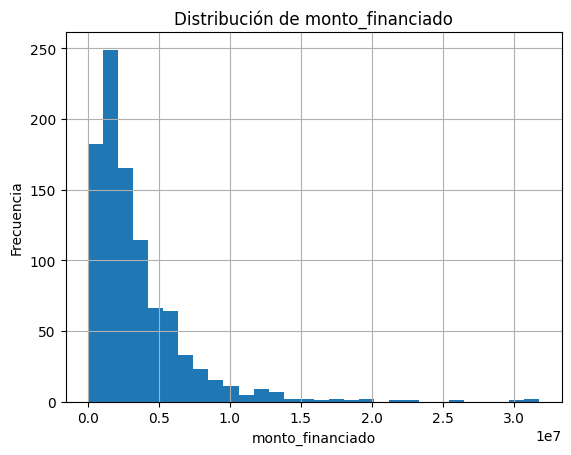

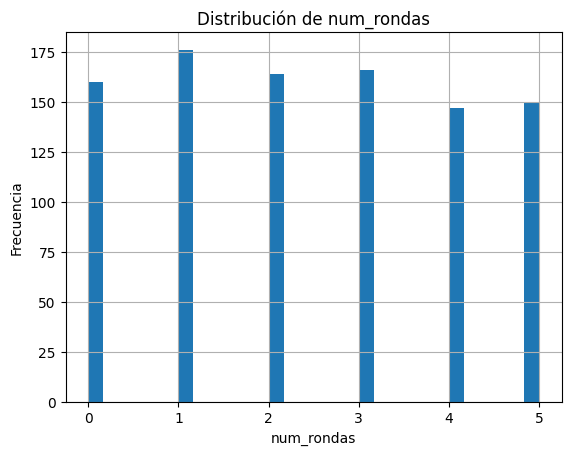

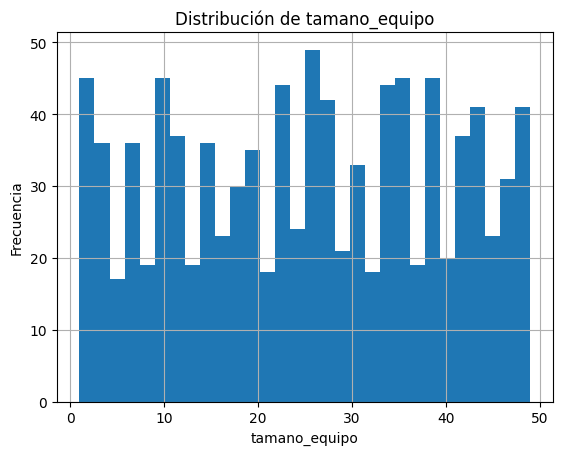

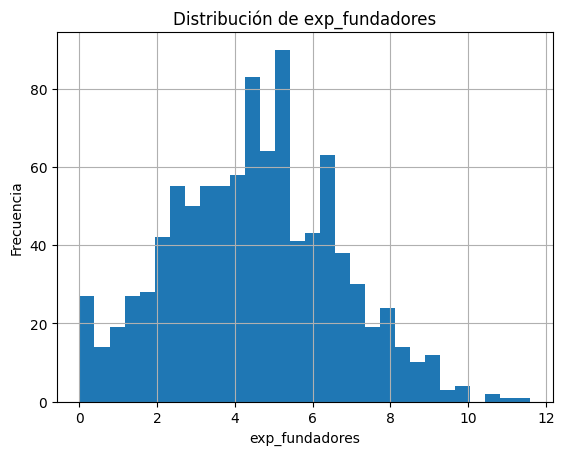

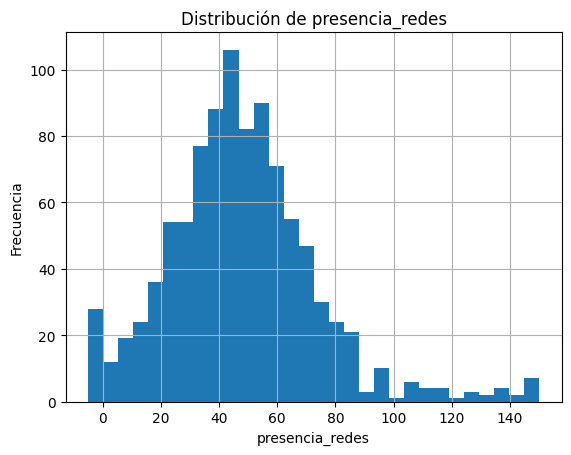

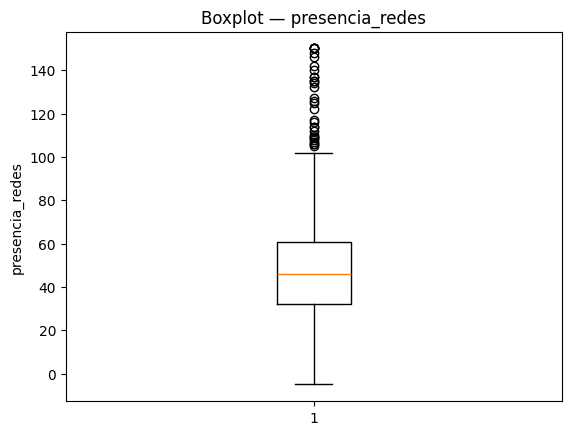

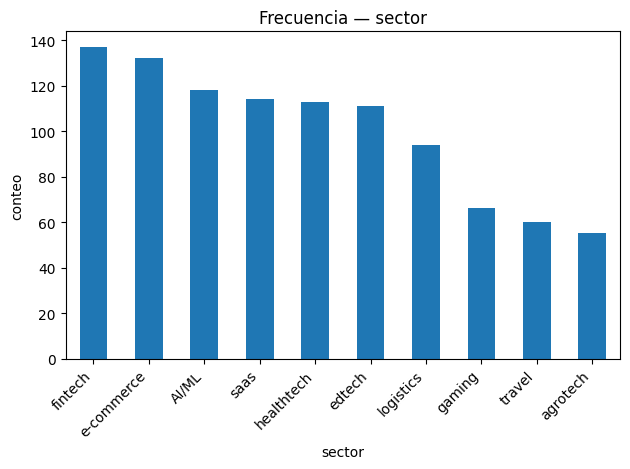

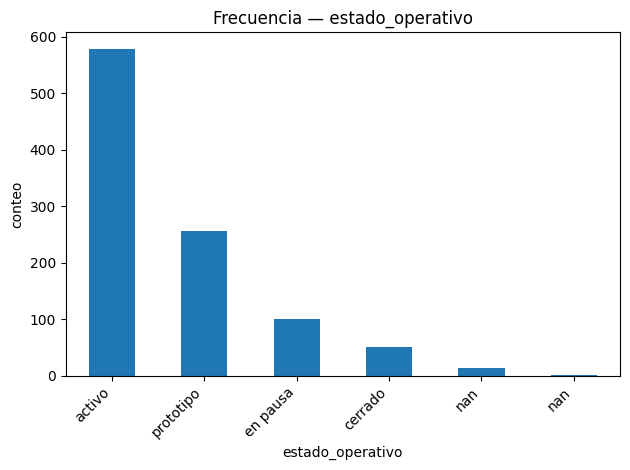

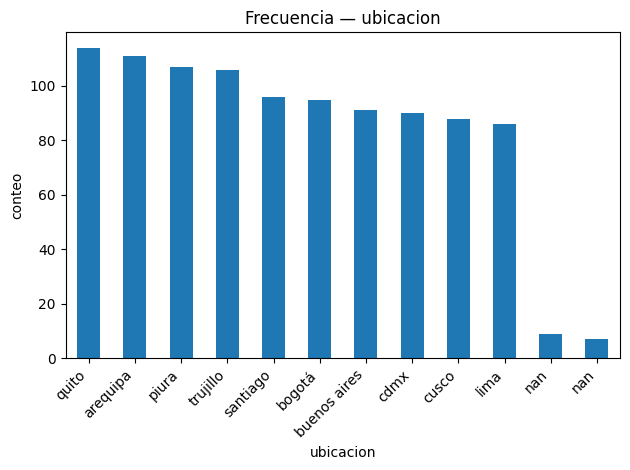

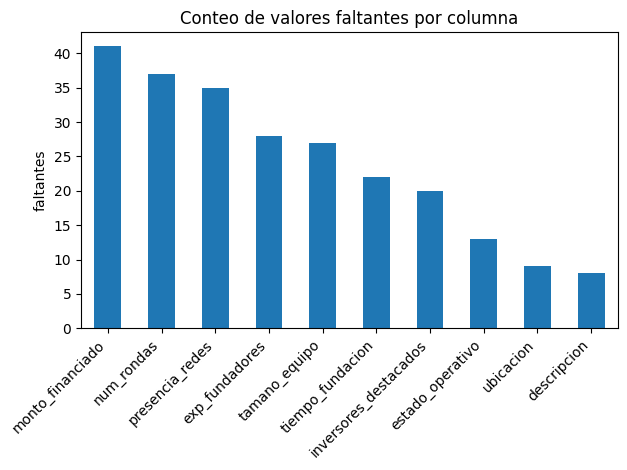

In [14]:
# Distribuciones básicas (matplotlib puro)
numeric_cols = ["monto_financiado","num_rondas","tamano_equipo","exp_fundadores","presencia_redes"]
for col in numeric_cols:
    if col in df.columns:
        plt.figure()
        df[col].hist(bins=30)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col); plt.ylabel("Frecuencia")
        plt.show()

# Boxplot de presencia_redes (outliers)
if "presencia_redes" in df.columns:
    plt.figure()
    plt.boxplot(df["presencia_redes"].dropna(), vert=True)
    plt.title("Boxplot — presencia_redes")
    plt.ylabel("presencia_redes")
    plt.show()

# Conteos categóricos
for col in ["sector","estado_operativo","ubicacion"]:
    if col in df.columns:
        plt.figure()
        df[col].value_counts(dropna=False).head(15).plot(kind="bar")
        plt.title(f"Frecuencia — {col}")
        plt.xlabel(col); plt.ylabel("conteo")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Faltantes (barra)
na_counts = df.isna().sum()
if na_counts.sum() > 0:
    plt.figure()
    na_counts[na_counts>0].sort_values(ascending=False).plot(kind="bar")
    plt.title("Conteo de valores faltantes por columna")
    plt.ylabel("faltantes"); plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## 4. Ingeniería mínima y guardado procesado (para modelado)

In [ ]:
# Imputación numérica simple (mediana) — ligera para poder modelar luego
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))

# Derivadas mínimas
if "presencia_redes" in df.columns:
    capped = df["presencia_redes"].clip(0,100)
    df["intensidad_redes"] = (np.minimum(capped,50)/50.0).round(4)

if "monto_financiado" in df.columns:
    df["log_monto"] = np.log1p(df["monto_financiado"]).round(6)

# Antigüedad
from datetime import datetime
now_year = datetime.now().year
if "tiempo_fundacion" in df.columns:
    df["antiguedad"] = (now_year - df["tiempo_fundacion"]).clip(lower=0)
    bins = [-1,1,3,7,100]; labels = ["0-1","2-3","4-7","8+"]
    df["antiguedad_bucket"] = pd.cut(df["antiguedad"], bins=bins, labels=labels)

# Cruces simples
if {"sector","estado_operativo"}.issubset(df.columns):
    df["sector_x_estado"] = df["sector"].astype(str) + "_" + df["estado_operativo"].astype(str)

# One-Hot de categóricos principales
cat_cols = [c for c in ["sector","ubicacion","estado_operativo","antiguedad_bucket"] if c in df.columns]
df_model = pd.get_dummies(df, columns=cat_cols, drop_first=False)

# Comprobación final
display(df_model.head())
print("Shape final:", df_model.shape)

# Guardar procesado
df_model.to_csv(processed_path, index=False, encoding="utf-8")
print(f"Guardado procesado en: {processed_path}")


,monto_financiado,num_rondas,tamano_equipo,exp_fundadores,presencia_redes,inversores_destacados,descripcion,tiempo_fundacion,viabilidad,flag_na_monto_financiado,...,ubicacion_trujillo,estado_operativo_activo,estado_operativo_cerrado,estado_operativo_en pausa,estado_operativo_nan,estado_operativo_prototipo,antiguedad_bucket_0-1,antiguedad_bucket_2-3,antiguedad_bucket_4-7,antiguedad_bucket_8+
0,1555000.0,2.0,49.0,8.7,8.5,0.0,equipo con 8+ años de experiencia. operando en...,2016.0,1,0,...,False,True,False,False,False,False,False,False,False,True
1,4217000.0,1.0,9.0,1.2,-5.0,0.0,operando en el mercado,2007.0,1,0,...,False,True,False,False,False,False,False,False,False,True
2,1224000.0,5.0,17.0,2.5,77.3,0.0,buena presencia en redes. operando en el merca...,2019.0,1,0,...,False,True,False,False,False,False,False,False,True,False
3,4922000.0,4.0,35.0,6.1,23.5,0.0,equipo con 6+ años de experiencia. operando en...,2017.0,0,0,...,False,True,False,False,False,False,False,False,False,True
4,2968000.0,3.0,38.0,2.9,5.4,1.0,apoyo de inversores reconocidos. operando en e...,2015.0,1,0,...,False,True,False,False,False,False,False,False,False,True


Shape final: (1000, 51)
Guardado procesado en: c:\Users\carlo\OneDrive\Escritorio\Proyecto Machine Learning\data\processed\startups_sintetico_1000_processed.csv


## 5. Resumen (para la diapositiva)
- Se normalizaron categóricos (espacios/case) y se parsearon formatos mixtos (*monto*, *rondas*, *año*, *Sí/No*).
"
- Se **inspeccionaron** distribuciones numéricas, outliers en `presencia_redes`, frecuencias por categoría y faltantes.
"
- Se aplicó imputación **mediana** (ligera) y se crearon derivadas clave (`intensidad_redes`, `log_monto`, `antiguedad_bucket`, `sector_x_estado`).
"
- Se generó el dataset **procesado** en `data/processed/startups_sintetico_1000_processed.csv` listo para el **notebook de modelado**.
"
- Métricas/curvas quedan para el notebook de entrenamiento (siguiente fase).